In [472]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,RobustScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV,SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute import KNNImputer
from sklearn.linear_model import SGDRegressor
sns.set_theme()

# EDA

In [411]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'
df = pd.read_csv(file_path)

#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [412]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [413]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [414]:
df.duplicated().values.any()

np.False_

In [415]:
df.describe()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [416]:
# Función para calcular la distancia del viaje en base a las coordenadas 
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radio de la Tierra en km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


In [417]:
def obtener_semana_mes(fecha):
    return min(int(np.ceil(fecha.day / 7)), 4)

In [418]:
# Creación de copia del df para evitar conflictos.
df_copy = df.copy()

In [419]:
df_copy.isna().sum()

key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

Se aprecian valores atípicos muy alejados de la media de los datos y valores negativos imposibles.

<Axes: ylabel='fare_amount'>

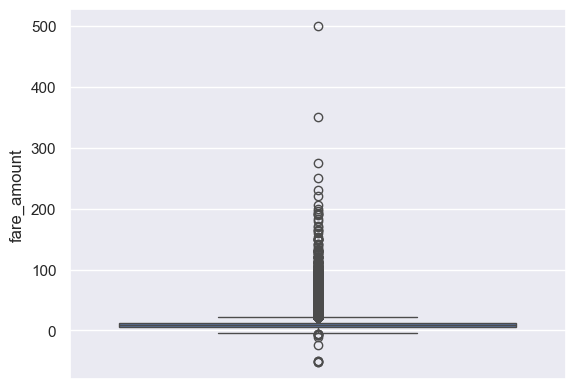

In [420]:
sns.boxplot(df_copy["fare_amount"])

In [421]:
# Filas con precios atípicos
df_copy[(df_copy["fare_amount"] > 200) | (df_copy["fare_amount"] < 0)]

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
4292,33491441,2014-10-24 20:20:00.000000181,350.00,2014-10-24 20:20:00 UTC,0.000000,0.000000,0.000000,0.000000,3
23682,38390943,2014-11-02 22:40:20.0000004,206.38,2014-11-02 22:40:20 UTC,-73.782161,40.644601,-74.449079,40.836457,1
29261,5471406,2013-09-27 12:36:11.0000002,220.00,2013-09-27 12:36:11 UTC,-73.801147,40.671653,-73.790402,40.646742,1
63395,30260042,2015-03-03 23:07:41.0000008,-5.00,2015-03-03 23:07:41 UTC,-73.992249,40.748936,-73.988518,40.748180,1
71246,51325304,2010-02-11 21:47:10.0000001,-3.30,2010-02-11 21:47:10 UTC,-73.952725,40.768235,-73.949928,40.772208,2
71715,38680012,2013-05-11 00:31:00.00000084,250.00,2013-05-11 00:31:00 UTC,0.000000,0.000000,0.000000,0.000000,1
79903,50284253,2015-05-01 14:43:02.0000004,-3.50,2015-05-01 14:43:02 UTC,-73.982430,40.775024,-73.981750,40.778439,1
89322,26673143,2010-03-09 08:26:10.0000006,-49.57,2010-03-09 08:26:10 UTC,-73.972772,40.785657,-73.972867,40.785500,5
92063,10267585,2010-03-12 08:49:10.0000002,-23.70,2010-03-12 08:49:10 UTC,-73.952740,40.768233,-74.007028,40.707338,3
98875,51135168,2015-03-20 21:31:14.0000007,-52.00,2015-03-20 21:31:14 UTC,-74.000359,40.728729,-74.005699,40.728680,5


In [422]:
len(df_copy[(df_copy["fare_amount"] > 200) | (df_copy["fare_amount"] < 0)])

24

filtramos estos valores atipicos de nuestra columna target

In [423]:
df_copy = df_copy[(df_copy["fare_amount"] < 200) & (df_copy["fare_amount"] > 0)] 

In [424]:
df_copy[df_copy["passenger_count"] > 7]

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
113038,35893772,2010-12-28 08:20:00.0000001,11.7,2010-12-28 08:20:00 UTC,-73.937795,40.758498,-73.937835,40.758415,208


In [425]:
# Eliminación de único valor atípico en la cantidad de pasajeros 
df_copy = df_copy[df_copy["passenger_count"] < 7]

Se observa que aproximadamente el 2% de las filas tienen mas de un valor faltanrte en las coordendas, lo que dificulta el cálculo de la distancia.

In [426]:
# Mas de 3 columnas de coordenadas con 0 lo filtramos
coords = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]
conteo_ceros = (df_copy[coords] == 0.0).sum(axis=1)
pd.Series(conteo_ceros).value_counts()

0    196007
4      3583
2       359
1        20
Name: count, dtype: int64

Eliminación de filas con coordenadas faltantes

In [427]:
df_copy = df_copy[conteo_ceros == 0]

In [ ]:
df_copy.dropna(inplace=True)
df_copy.reset_index(drop=True, inplace=True) 

# Ingenieria de caracteristicas

In [432]:
# Conversión de tipo de datos y creación de columnas. 
df_copy["passenger_count"] = df_copy["passenger_count"].astype("Int64")
df_copy['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])


In [433]:
df_copy['dia_semana'] = df_copy['pickup_datetime'].dt.weekday
n = 7
df_copy["dia_sin"] = np.sin(2 * np.pi * df_copy["dia_semana"] / n)
df_copy["dia_cos"] = np.cos(2 * np.pi * df_copy["dia_semana"] / n)

In [434]:
# Extraer la hora del pickup_datetime
df_copy['hora'] = df_copy['pickup_datetime'].dt.hour

# Aplicar transformación trigonométrica para la hora (ciclo de 24 horas)
n = 24
df_copy["hora_sin"] = np.sin(2 * np.pi * df_copy["hora"] / n)
df_copy["hora_cos"] = np.cos(2 * np.pi * df_copy["hora"] / n)


In [435]:
df_copy.drop(columns=["dia_semana","hora"], inplace=True) #borramos columnas que ya no usaremos

In [436]:
df_copy["distance_km"] = haversine(
    df_copy["pickup_latitude"], df_copy["pickup_longitude"],
    df_copy["dropoff_latitude"], df_copy["dropoff_longitude"]
)

In [437]:
# Eliminación de columna redundante, igual que pickup_datetime
df_copy = df_copy.drop("date",axis=1)

In [438]:
df_copy["semana_mes"] = df_copy["pickup_datetime"].apply(obtener_semana_mes)

In [439]:
df_copy.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes
0,24238194,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,0.433884,-0.900969,-0.965926,0.258819,1.683323,1
1,27835199,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,-0.433884,-0.900969,-0.866025,0.500000,2.457590,3
2,44984355,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,0.000000,1.000000,-0.707107,0.707107,5.036377,4
3,25894730,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,-0.433884,-0.900969,0.866025,-0.500000,1.661683,4
4,17610152,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,0.433884,-0.900969,-0.965926,-0.258819,4.475450,4


In [440]:
df_copy["semana_mes"].value_counts()

semana_mes
4    59413
2    46378
3    46305
1    43910
Name: count, dtype: int64

In [441]:
coords = ["key","pickup_datetime" ,"pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]
df_copy.drop(columns=coords, inplace=True)

In [442]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196006 entries, 0 to 196005
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   fare_amount      196006 non-null  float64
 1   passenger_count  196006 non-null  Int64  
 2   dia_sin          196006 non-null  float64
 3   dia_cos          196006 non-null  float64
 4   hora_sin         196006 non-null  float64
 5   hora_cos         196006 non-null  float64
 6   distance_km      196006 non-null  float64
 7   semana_mes       196006 non-null  int64  
dtypes: Int64(1), float64(6), int64(1)
memory usage: 12.2 MB


In [443]:
# Creación de dummies en columna franja horaria
encoder = OneHotEncoder(sparse_output=False, drop='first')  

encoded = encoder.fit_transform(df_copy[['semana_mes', 'passenger_count']])

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['semana_mes', 'passenger_count']))

df_encoded = pd.concat([df_copy.drop(columns=['semana_mes', 'passenger_count']), encoded_df], axis=1)

df_encoded.head()


,fare_amount,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
0,7.5,0.433884,-0.900969,-0.965926,0.258819,1.683323,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,7.7,-0.433884,-0.900969,-0.866025,0.500000,2.457590,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,12.9,0.000000,1.000000,-0.707107,0.707107,5.036377,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,5.3,-0.433884,-0.900969,0.866025,-0.500000,1.661683,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,16.0,0.433884,-0.900969,-0.965926,-0.258819,4.475450,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [444]:
cols_dummies = [c for c in df_encoded.columns if c.startswith("semana_mes_") or c.startswith("passenger_count_")]
df_encoded[cols_dummies] = df_encoded[cols_dummies].astype('Int32')

In [445]:
not_dummy_cols = ["fare_amount","dia_sin","dia_cos","hora_sin","hora_cos","distance_km"]
df_encoded[not_dummy_cols] = df_encoded[not_dummy_cols].astype("float32")

In [446]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196006 entries, 0 to 196005
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   fare_amount          196006 non-null  float32
 1   dia_sin              196006 non-null  float32
 2   dia_cos              196006 non-null  float32
 3   hora_sin             196006 non-null  float32
 4   hora_cos             196006 non-null  float32
 5   distance_km          196006 non-null  float32
 6   semana_mes_2         196006 non-null  Int32  
 7   semana_mes_3         196006 non-null  Int32  
 8   semana_mes_4         196006 non-null  Int32  
 9   passenger_count_1.0  196006 non-null  Int32  
 10  passenger_count_2.0  196006 non-null  Int32  
 11  passenger_count_3.0  196006 non-null  Int32  
 12  passenger_count_4.0  196006 non-null  Int32  
 13  passenger_count_5.0  196006 non-null  Int32  
 14  passenger_count_6.0  196006 non-null  Int32  
dtypes: Int32(9), floa

# Modelo de regresion

In [448]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns='fare_amount'), df_encoded['fare_amount'], test_size=0.2, random_state=42)

In [449]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156804 entries, 72653 to 121958
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dia_sin              156804 non-null  float32
 1   dia_cos              156804 non-null  float32
 2   hora_sin             156804 non-null  float32
 3   hora_cos             156804 non-null  float32
 4   distance_km          156804 non-null  float32
 5   semana_mes_2         156804 non-null  Int32  
 6   semana_mes_3         156804 non-null  Int32  
 7   semana_mes_4         156804 non-null  Int32  
 8   passenger_count_1.0  156804 non-null  Int32  
 9   passenger_count_2.0  156804 non-null  Int32  
 10  passenger_count_3.0  156804 non-null  Int32  
 11  passenger_count_4.0  156804 non-null  Int32  
 12  passenger_count_5.0  156804 non-null  Int32  
 13  passenger_count_6.0  156804 non-null  Int32  
dtypes: Int32(9), float32(5)
memory usage: 10.9 MB


In [450]:
X_train[X_train["distance_km"] == 0]

,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
17481,0.974928,-0.222521,7.071068e-01,-0.707107,0.0,0,0,1,1,0,0,0,0,0
27864,-0.974928,-0.222521,-8.660254e-01,0.500000,0.0,0,0,1,1,0,0,0,0,0
75444,-0.433884,-0.900969,7.071068e-01,-0.707107,0.0,0,0,1,0,0,1,0,0,0
190576,0.781832,0.623490,-5.000000e-01,-0.866025,0.0,0,1,0,1,0,0,0,0,0
17207,0.000000,1.000000,1.224647e-16,-1.000000,0.0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9348,-0.433884,-0.900969,-5.000000e-01,0.866025,0.0,1,0,0,0,0,0,0,0,1
166267,-0.781832,0.623490,-5.000000e-01,0.866025,0.0,0,0,1,1,0,0,0,0,0
83613,0.781832,0.623490,-7.071068e-01,0.707107,0.0,0,0,1,1,0,0,0,0,0
87922,-0.433884,-0.900969,5.000000e-01,-0.866025,0.0,0,1,0,1,0,0,0,0,0


In [451]:
X_train[X_train["distance_km"] < 0.1]

,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
17481,0.974928,-0.222521,0.707107,-7.071068e-01,0.000000,0,0,1,1,0,0,0,0,0
41903,0.974928,-0.222521,-0.707107,7.071068e-01,0.000084,0,0,1,1,0,0,0,0,0
153451,0.433884,-0.900969,0.965926,-2.588190e-01,0.012473,0,0,1,1,0,0,0,0,0
151661,-0.433884,-0.900969,-0.866025,-5.000000e-01,0.026987,0,0,1,1,0,0,0,0,0
27864,-0.974928,-0.222521,-0.866025,5.000000e-01,0.000000,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133272,0.974928,-0.222521,-0.258819,-9.659258e-01,0.000000,0,1,0,1,0,0,0,0,0
96601,-0.781832,0.623490,0.500000,-8.660254e-01,0.001560,0,1,0,1,0,0,0,0,0
90084,0.781832,0.623490,-1.000000,-1.836970e-16,0.010957,0,0,1,1,0,0,0,0,0
64044,0.000000,1.000000,0.500000,-8.660254e-01,0.022474,0,0,0,0,0,0,1,0,0


In [452]:
# Muy pocos viajes en los nuevos dataset con distancias mayores a 60
X_train[X_train["distance_km"] > 90].shape[0], X_test[X_test["distance_km"] > 90].shape[0]

(83, 26)

In [453]:
# Muy pocos viajes en los nuevos dataset con distancias mayores a 60
X_train[X_train["distance_km"] < 0.1].shape[0], X_test[X_test["distance_km"] < 0.1].shape[0]

(2562, 651)

In [454]:
# Conversión de atípico a Nan para imputación futura 
X_train.loc[(X_train["distance_km"] > 90) | (X_train["distance_km"] < 0.1), "distance_km"] = np.nan

In [455]:
X_test.loc[(X_test["distance_km"] > 90) | (X_test["distance_km"] < 0.1), "distance_km"] = np.nan

<Axes: xlabel='distance_km', ylabel='Count'>

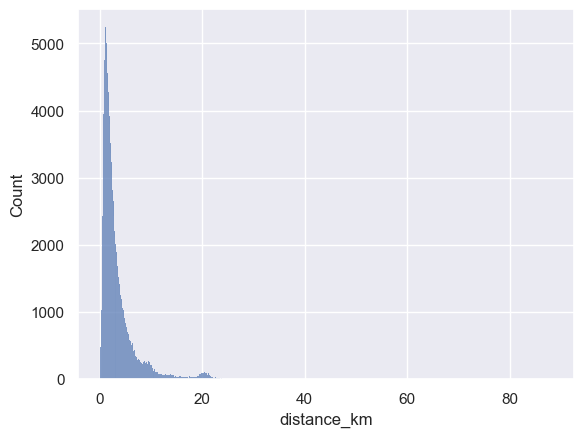

In [456]:
sns.histplot(X_train["distance_km"])

In [457]:
X_train[[column for column in X_train.columns if column != "key"]].describe()

,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
count,156804.000000,156804.000000,156804.000000,156804.000000,154159.000000,156804.0,156804.0,156804.0,156804.0,156804.0,156804.0,156804.0,156804.0,156804.0
mean,-0.002527,-0.044347,-0.194708,-0.068447,3.364864,0.237022,0.236359,0.302677,0.691825,0.147394,0.044195,0.021173,0.070241,0.021753
std,0.711470,0.701316,0.668873,0.714156,3.598838,0.425257,0.424846,0.459418,0.461741,0.3545,0.205529,0.143961,0.255553,0.145877
min,-0.974928,-0.900969,-1.000000,-1.000000,0.100227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-0.781832,-0.900969,-0.866025,-0.707107,1.293430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,-0.222521,-0.258819,-0.258819,2.193798,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
75%,0.781832,0.623490,0.500000,0.707107,3.946942,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
max,0.974928,1.000000,1.000000,1.000000,88.129547,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [458]:
# Todas las columnas numéricas
cols_to_impute = X_train.columns  

# Instanciar imputador
knn_imputer = KNNImputer(n_neighbors=5)

# Fit en train, transform en train y test
X_train_imputed = pd.DataFrame(
    knn_imputer.fit_transform(X_train[cols_to_impute]),
    columns=cols_to_impute,
    index=X_train.index
)
X_test_imputed = pd.DataFrame(
    knn_imputer.transform(X_test[cols_to_impute]),
    columns=cols_to_impute,
    index=X_test.index
)

# Sobrescribís solo la columna distance_km si no querés tocar las demás
X_train["distance_km"] = X_train_imputed["distance_km"]
X_test["distance_km"] = X_test_imputed["distance_km"]

In [459]:
X_train[[column for column in X_train.columns if column != "key"]].describe()

,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
count,156804.000000,156804.000000,156804.000000,156804.000000,156804.000000,156804.0,156804.0,156804.0,156804.0,156804.0,156804.0,156804.0,156804.0,156804.0
mean,-0.002527,-0.044347,-0.194708,-0.068447,3.364365,0.237022,0.236359,0.302677,0.691825,0.147394,0.044195,0.021173,0.070241,0.021753
std,0.711470,0.701316,0.668873,0.714156,3.574228,0.425257,0.424846,0.459418,0.461741,0.3545,0.205529,0.143961,0.255553,0.145877
min,-0.974928,-0.900969,-1.000000,-1.000000,0.100227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-0.781832,-0.900969,-0.866025,-0.707107,1.305595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,-0.222521,-0.258819,-0.258819,2.212115,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
75%,0.781832,0.623490,0.500000,0.707107,3.951456,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
max,0.974928,1.000000,1.000000,1.000000,88.129547,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<Axes: xlabel='distance_km', ylabel='Count'>

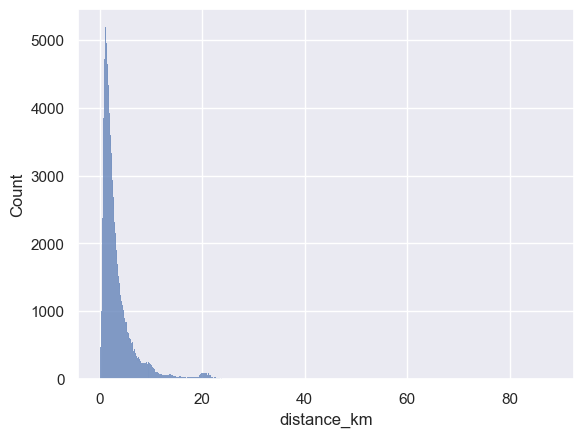

In [460]:
sns.histplot(X_train["distance_km"])

In [461]:
cols = ['distance_km']
scaler = StandardScaler()
# Copiar los DataFrames para no modificar los originales
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
# Escalar solo las columnas especificadas
X_train_scaled[cols] = scaler.fit_transform(X_train[cols])
X_test_scaled[cols] = scaler.transform(X_test[cols])

In [462]:
pd.DataFrame(X_test_scaled,columns=X_test.columns).describe()

,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
count,39202.000000,39202.000000,39202.000000,39202.000000,39202.000000,39202.0,39202.0,39202.0,39202.0,39202.0,39202.0,39202.0,39202.0,39202.0
mean,0.004353,-0.042624,-0.196748,-0.070399,0.010266,0.234988,0.235779,0.304882,0.692516,0.146676,0.045278,0.022014,0.069512,0.020178
std,0.710212,0.702701,0.667914,0.714317,1.018463,0.423997,0.42449,0.460363,0.461458,0.353787,0.207917,0.146731,0.254326,0.140609
min,-0.974928,-0.900969,-1.000000,-1.000000,-0.913189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-0.781832,-0.900969,-0.866025,-0.707107,-0.574581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,-0.222521,-0.258819,-0.258819,-0.325178,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
75%,0.781832,0.623490,0.500000,0.707107,0.176026,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
max,0.974928,1.000000,1.000000,1.000000,17.018678,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [463]:
# crear un pipeline para la preprocesamiento y el modelo
pipeline = Pipeline([ 
    ('Linear', LinearRegression())  
])

# ajustar el modelo a los datos de entrenamiento
pipeline.fit(X_train_scaled, y_train)

# hacer predicciones con el conjunto de prueba
y_pred = pipeline.predict(X_test_scaled)

In [464]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


MAE: 2.42
RMSE: 4.82
R²: 0.76


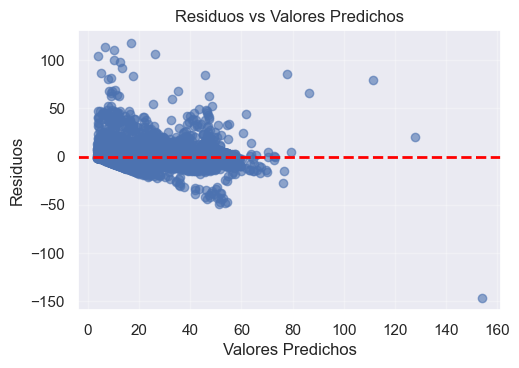

In [468]:
residuos = y_test - y_pred

# Crear gráfico de residuos
plt.figure(figsize=(12, 8))

# Gráfico 1: Residuos vs Valores Predichos
plt.subplot(2, 2, 1)
plt.scatter(y_pred, residuos, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Predichos')
plt.grid(True, alpha=0.3)

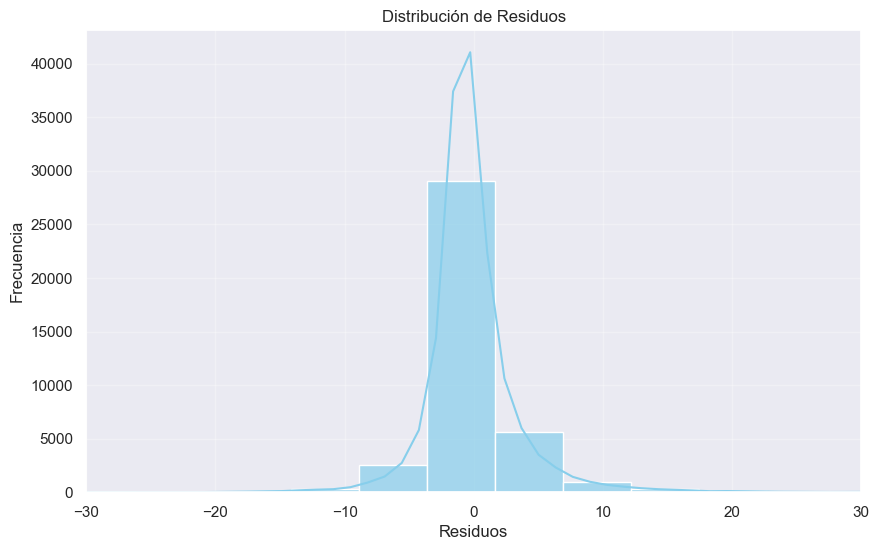

In [470]:
plt.figure(figsize=(10, 6))
sns.histplot(residuos, bins=50, color='skyblue', alpha=0.7, kde=True)
plt.xlim(-30, 30)  # Ajusta según tus datos
plt.title('Distribución de Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
plt.show()

Visualización de coeficientes.

In [471]:
regressor = pipeline.named_steps['Linear']

# Obtener coeficientes
coefs = regressor.coef_

# Crear DataFrame que relacione variable con su coeficiente
coef_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Coeficiente': coefs
})

print(coef_df)

               Variable  Coeficiente
0               dia_sin    -0.012183
1               dia_cos     0.000889
2              hora_sin    -0.035993
3              hora_cos    -0.017062
4           distance_km     8.381547
5          semana_mes_2    -0.024411
6          semana_mes_3     0.004232
7          semana_mes_4     0.017777
8   passenger_count_1.0     1.110649
9   passenger_count_2.0     1.192859
10  passenger_count_3.0     1.194846
11  passenger_count_4.0     1.318813
12  passenger_count_5.0     1.007033
13  passenger_count_6.0     1.780960


# Gradiente 

In [227]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))
    

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W) 
        error_test = y_val - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W



In [228]:
# Escalado para correcto funcionamiento de GD
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

scaler_y = StandardScaler()

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

Época 10/100, Train MSE: 23.6233, Test MSE: 23.1090
Época 20/100, Train MSE: 23.2174, Test MSE: 22.7258
Época 30/100, Train MSE: 23.0586, Test MSE: 22.5749
Época 40/100, Train MSE: 22.9664, Test MSE: 22.4860
Época 50/100, Train MSE: 22.9046, Test MSE: 22.4261
Época 60/100, Train MSE: 22.8607, Test MSE: 22.3833
Época 70/100, Train MSE: 22.8283, Test MSE: 22.3519
Época 80/100, Train MSE: 22.8038, Test MSE: 22.3283
Época 90/100, Train MSE: 22.7851, Test MSE: 22.3104
Época 100/100, Train MSE: 22.7705, Test MSE: 22.2965


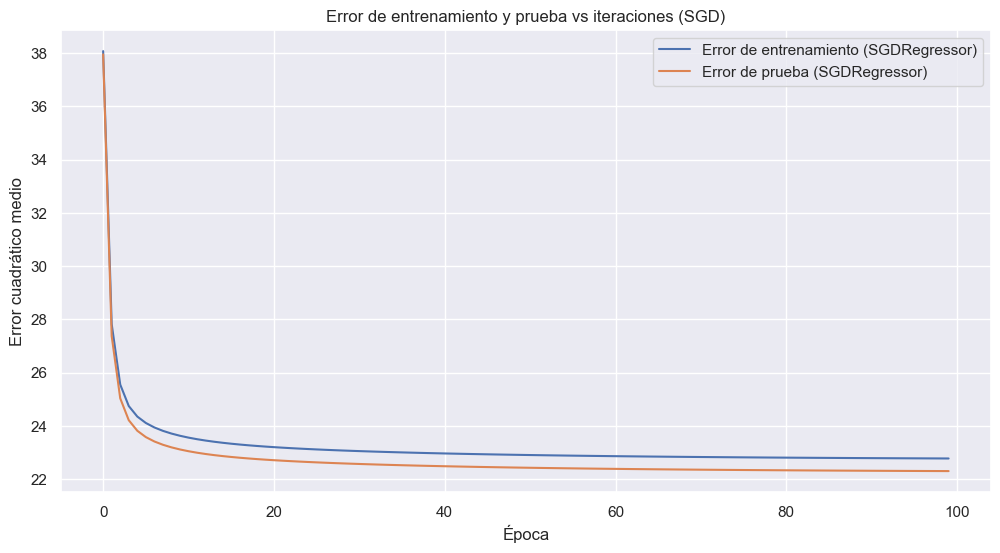

Época 10/50, Train MSE: 23.6231, Test MSE: 23.1094
Época 20/50, Train MSE: 23.2182, Test MSE: 22.7270
Época 30/50, Train MSE: 23.0591, Test MSE: 22.5756
Época 40/50, Train MSE: 22.9667, Test MSE: 22.4866
Época 50/50, Train MSE: 22.9048, Test MSE: 22.4266


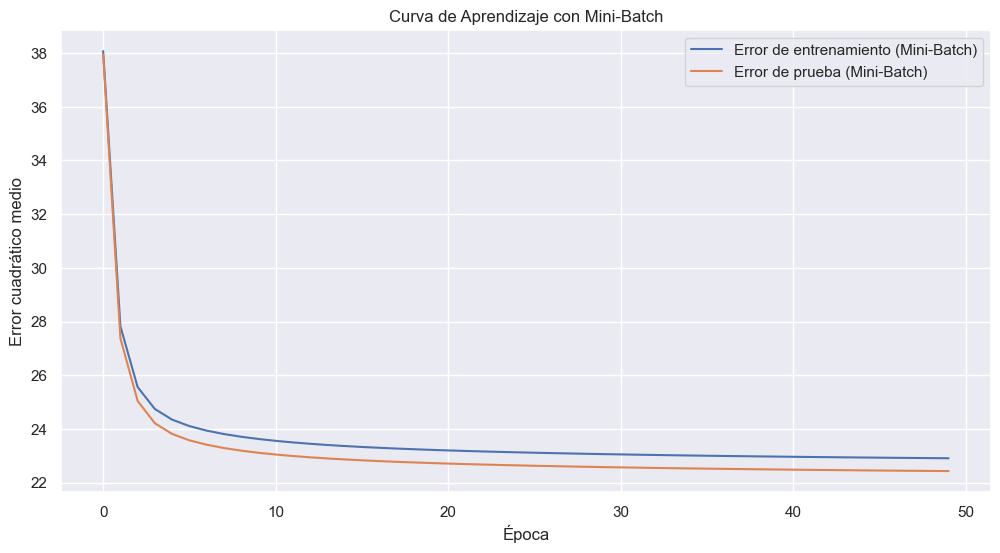

In [ ]:
# Codigo sgd y minibatch

y_train_flat = y_train.ravel()
y_test_flat = y_test.ravel()



warm_start=True 
max_iter=1 
sgd = SGDRegressor(
    max_iter=1,
    tol=None,
    penalty=None,  
    learning_rate='invscaling',  # Tasa de aprendizaje constante
    eta0=0.0001,  # lr
    warm_start=True, 
    random_state=42 
)


epochs = 100
train_errors = []
test_errors = []

for epoch in range(epochs):
    # Entrenamiento parcial
    sgd.partial_fit(X_train_scaled, y_train_flat)

    y_train_pred = sgd.predict(X_train_scaled)
    train_mse = mean_squared_error(y_train_flat, y_train_pred)
    train_errors.append(train_mse)

    y_test_pred = sgd.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test_flat, y_test_pred)
    test_errors.append(test_mse)

    if (epoch + 1) % 10 == 0:
      print(f"Época {epoch+1}/{epochs}, Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")


plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_errors, label='Error de entrenamiento (SGDRegressor)')
plt.plot(range(epochs), test_errors, label='Error de prueba (SGDRegressor)')
plt.xlabel('Época')
plt.ylabel('Error cuadrático medio')
plt.legend()
plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
plt.grid(True)
plt.show()

X_train_scaled_array = X_train_scaled.values  
X_test_scaled_array = X_test_scaled.values


sgd = SGDRegressor(
    max_iter=1,  # Controlamos las épocas manualmente
    tol=None,
    penalty=None,
    learning_rate='invscaling',
    eta0=0.0001,  
    warm_start=True, 
    random_state=42
)


epochs = 50
batch_size = 100 
n_samples = X_train_scaled_array.shape[0]

train_errors = []
test_errors = []


for epoch in range(epochs):


    permutation = np.random.permutation(n_samples)
    X_train_shuffled = X_train_scaled_array[permutation]
    y_train_shuffled = y_train_flat[permutation]


    for j in range(0, n_samples, batch_size):
        # Tomar un lote
        x_batch = X_train_shuffled[j:j + batch_size]
        y_batch = y_train_shuffled[j:j + batch_size]

        sgd.partial_fit(x_batch, y_batch)

    # Después de pasar por todos los lotes (una época completa), medir el error
    y_train_pred = sgd.predict(X_train_scaled_array)
    train_mse = mean_squared_error(y_train_flat, y_train_pred)
    train_errors.append(train_mse)

    y_test_pred = sgd.predict(X_test_scaled_array)
    test_mse = mean_squared_error(y_test_flat, y_test_pred)
    test_errors.append(test_mse)

    if (epoch + 1) % 10 == 0:
        print(f"Época {epoch+1}/{epochs}, Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")


plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_errors, label='Error de entrenamiento (Mini-Batch)')
plt.plot(range(epochs), test_errors, label='Error de prueba (Mini-Batch)')
plt.xlabel('Época')
plt.ylabel('Error cuadrático medio')
plt.legend()
plt.title('Curva de Aprendizaje con Mini-Batch')
plt.grid(True)
plt.show()

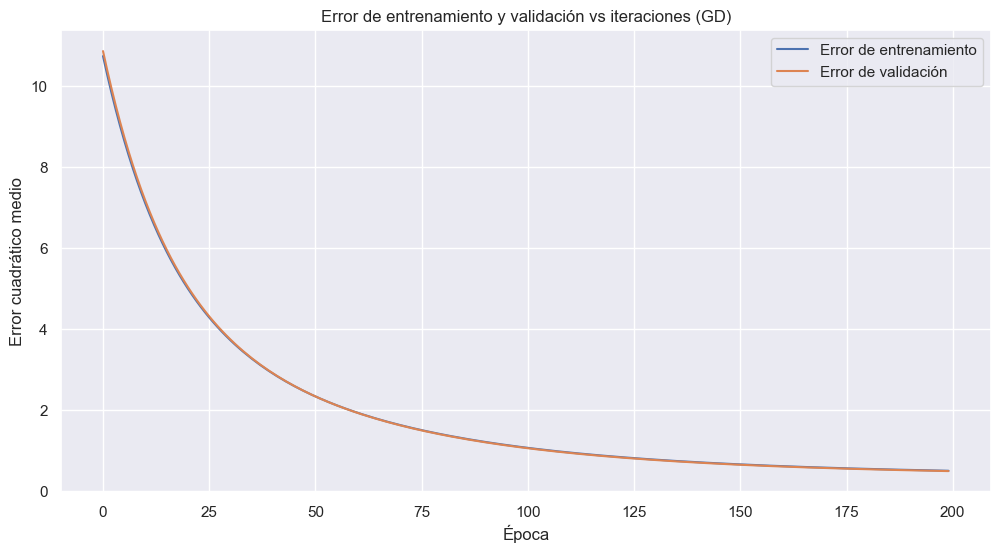

array([[-0.46542515149483044],
       [-0.2895864258829717],
       [-0.037928963839474916],
       [0.23685115883360347],
       [-0.08002477040435112],
       [0.8350183635364327],
       [0.20472873963970792],
       [0.2362890231775847],
       [0.115633817644753],
       [0.4184817735319027],
       [0.48864030377564954],
       [1.4388620690936438],
       [-0.6268950467494031],
       [-0.6144625042178863],
       [-0.5529537612032615]], dtype=object)

In [230]:
gradient_descent(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, lr=0.01, epochs=200)

# Regularización

## Ridge

In [487]:
# Creación y entrenamiento del modelo. Scikit-Learn usa Cross Validation para encontrar el valor óptimo de alpha
# (lambda en los desarrollos de teoría). Puede ser problemático con series de tiempo.

model_ridge = make_pipeline(RidgeCV(alphas = np.logspace(-3, 6, 200),
                              fit_intercept   = True,
                              store_cv_results = True
                        )
         )

model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test)
r2_ridge = r2_score(y_test,y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test,y_pred_ridge))
alpha_optimo = model_ridge.named_steps['ridgecv'].alpha_
print(f"Alpha optimo: {alpha_optimo}.")
print(f"R2: {r2_ridge}.")
print(f"RMSE: {rmse_ridge}.")
r2_ridge, rmse_ridge.item()

Alpha optimo: 1.1895340673703196.
R2: 0.7567379535519347.
RMSE: 4.820695734721481.


(0.7567379535519347, 4.820695734721481)

In [488]:
y_pred_ridge = pd.DataFrame(y_pred_ridge)
y_test_scaled = pd.DataFrame(y_test_scaled)

In [489]:
residuos_ridge = y_test - y_pred_ridge

# Gráfico 1: Residuos vs Valores Predichos
plt.scatter(y_pred_ridge, residuos_ridge, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Predichos')
plt.grid(True, alpha=0.3)

MemoryError: Unable to allocate 11.5 GiB for an array with shape (39202, 39202) and data type float64

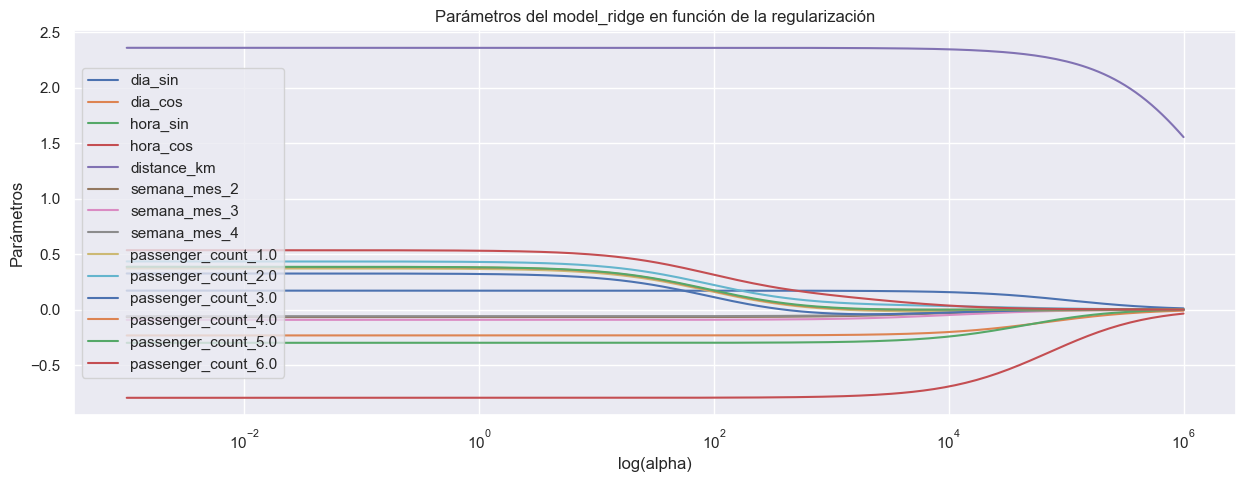

In [ ]:
# Evolución de los parámetros en función de alpha

alphas = model_ridge.steps[0][1].alphas
coefs = []

for alpha in alphas:
    model_ridge_aux = make_pipeline(Ridge(alpha=alpha))
    model_ridge_aux.fit(X_train, y_train)
    coefs.append(model_ridge_aux.steps[0][1].coef_.flatten())

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del model_ridge en función de la regularización');
plt.axis('tight')
plt.legend()
plt.show()

## Lasso

In [235]:
# Creación y entrenamiento del modelo. Scikit-Learn usa Cross Validation para encontrar el valor óptimo de alpha
# (lambda en los desarrollos de teoría). Puede ser problemático con series de tiempo.

model_lasso = make_pipeline(LassoCV(alphas = np.logspace(-3, 6, 200),
                              fit_intercept = True,
                              cv = 5
                        )
         )

model_lasso.fit(X_train, y_train)

y_pred_lasso= model_lasso.predict(X_test)
r2_lasso= r2_score(y_test,y_pred_lasso)
rmse_lasso= np.sqrt(mean_squared_error(y_test,y_pred_lasso))
alpha_optimo_lasso = model_lasso.named_steps['lassocv'].alpha_
print(f"rmse:{rmse_lasso}")
print(f"r2:{r2_lasso}")
print(f"Alpha optimo: {alpha_optimo_lasso}.")
r2_lasso, rmse_lasso

c:\Users\Thinkpad\Documents\aa1\AA1-TUIA-2025C2-Canciani-Morales-Mancini\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


rmse:4.714215098237659
r2:0.7662845303329847
Alpha optimo: 0.00890735463861044.


(0.7662845303329847, np.float64(4.714215098237659))

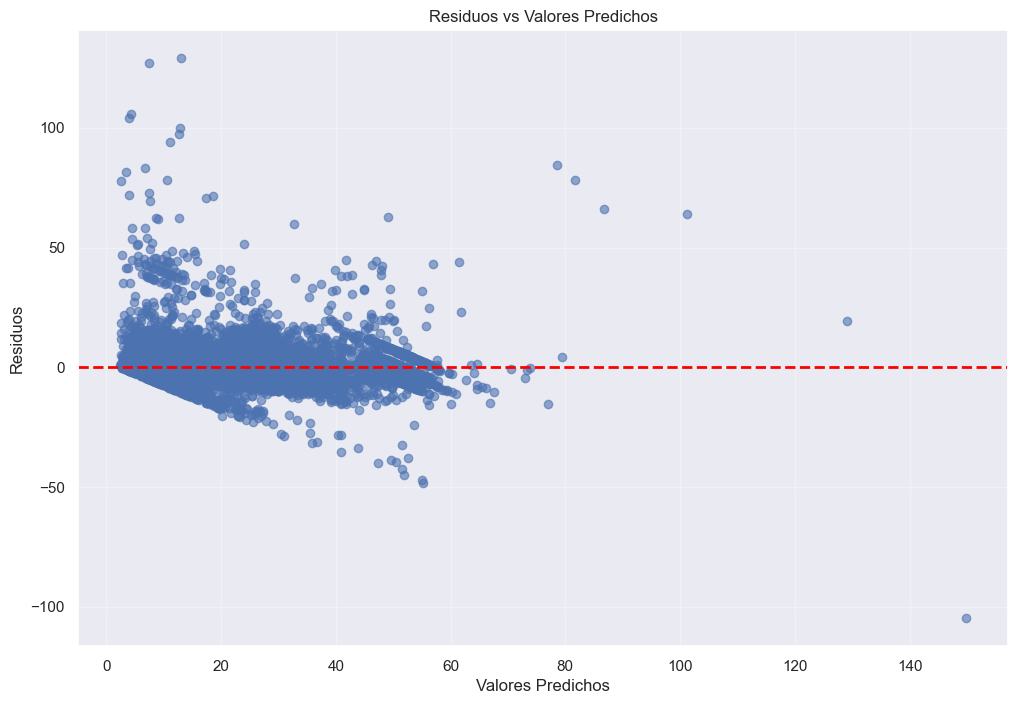

In [236]:
residuos_ridge = y_test - y_pred_ridge

# Crear gráfico de residuos
plt.figure(figsize=(12, 8))

# Gráfico 1: Residuos vs Valores Predichos
plt.scatter(y_pred_ridge, residuos, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Predichos')
plt.grid(True, alpha=0.3)

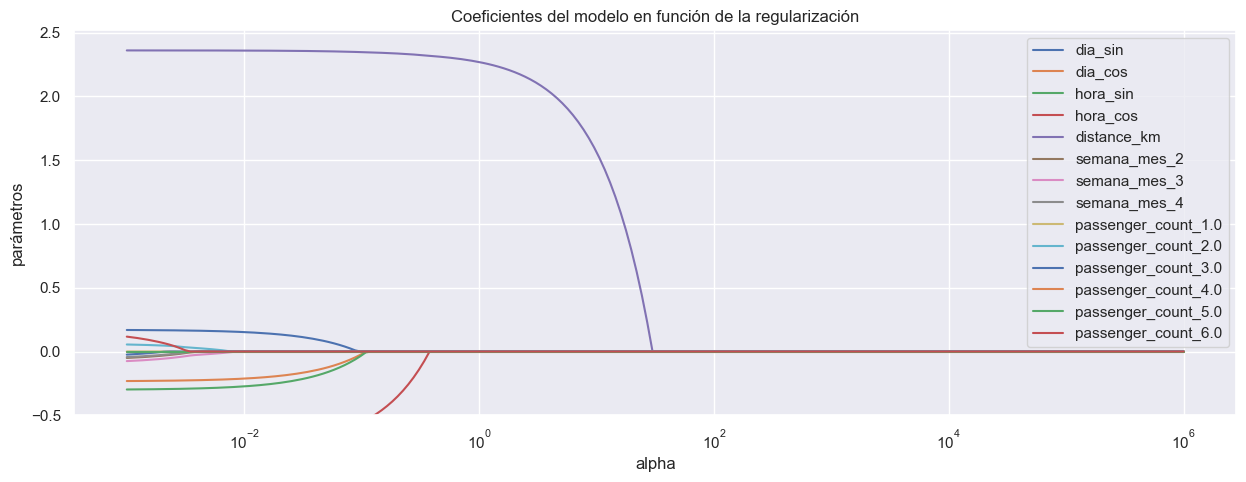

In [237]:
# Evolución de los parámetros en función de alpha

mod = model_lasso.steps[0][1]

alphas = mod.alphas_
coefs = []

for alpha in alphas:
    model_lasso_aux = make_pipeline(Lasso(alpha=alpha))
    model_lasso_aux.fit(X_train, y_train)
    coefs.append(model_lasso_aux.steps[0][1].coef_.flatten())

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')
ax.legend()
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.show()

## ElasticNet

In [238]:
model_elastic = make_pipeline(ElasticNetCV(
                              l1_ratio= [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
                              alphas = np.logspace(-3, 4, 200),
                              cv = 5
                           )
         )

_ = model_elastic.fit(X_train, y_train)

mod = model_elastic.steps[0][1];

c:\Users\Thinkpad\Documents\aa1\AA1-TUIA-2025C2-Canciani-Morales-Mancini\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Thinkpad\Documents\aa1\AA1-TUIA-2025C2-Canciani-Morales-Mancini\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Thinkpad\Documents\aa1\AA1-TUIA-2025C2-Canciani-Morales-Mancini\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. 

In [239]:
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio
mean_error_cv = mod.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha) se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [mod.l1_ratio, mod.alphas_],
                                    names     = ['l1_ratio', 'mod.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
rmse_elastic_net = df_resultados_cv['rmse_cv'].min()
df_resultados_cv

,l1_ratio,mod.alphas_,mse_cv,rmse_cv
1372,0.99,0.008907,22.707025,4.765189
1373,0.99,0.008214,22.707032,4.765190
1371,0.99,0.009659,22.707040,4.765190
1172,0.95,0.008907,22.707044,4.765191
1171,0.95,0.009659,22.707055,4.765192
...,...,...,...,...
653,0.70,136.671636,93.439580,9.666415
654,0.70,126.038293,93.439580,9.666415
660,0.70,77.525975,93.439580,9.666415
661,0.70,71.494290,93.439580,9.666415


Se puede observar que el mejor rmse se obtiene dejando un 0.1 de Lasso en el modelo de Elastic-Net. Esto ocurre porque, al haber coeficientes chicos de algunas variables, Ridge hace que valgan 0 demasiado rápido, haciendo que el modelo quede con menos informacion.  

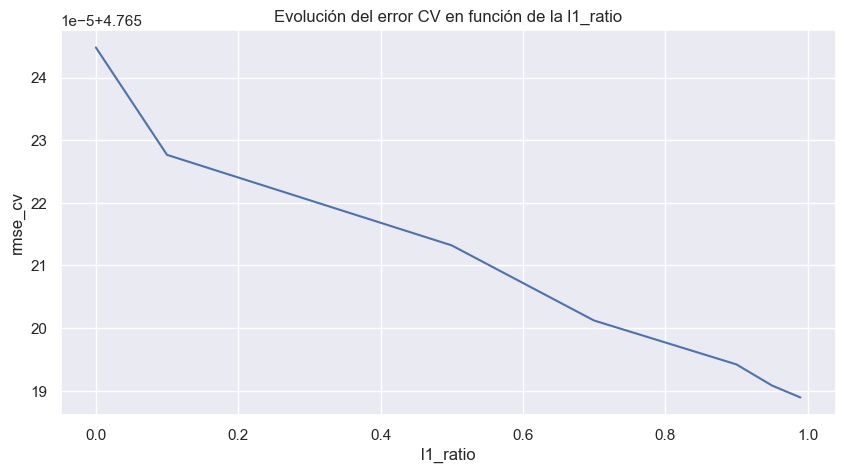

In [240]:
fig, ax = plt.subplots(figsize=(10, 5))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

In [241]:
# Mejor valor alpha y l1_ratio_ encontrado

print(f"Mejor valor de alpha encontrado: {mod.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {mod.l1_ratio_}")

Mejor valor de alpha encontrado: 0.00890735463861044
Mejor valor de l1_ratio encontrado: 0.99


In [242]:
# Parámetros del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': mod.coef_.flatten()}
                  )

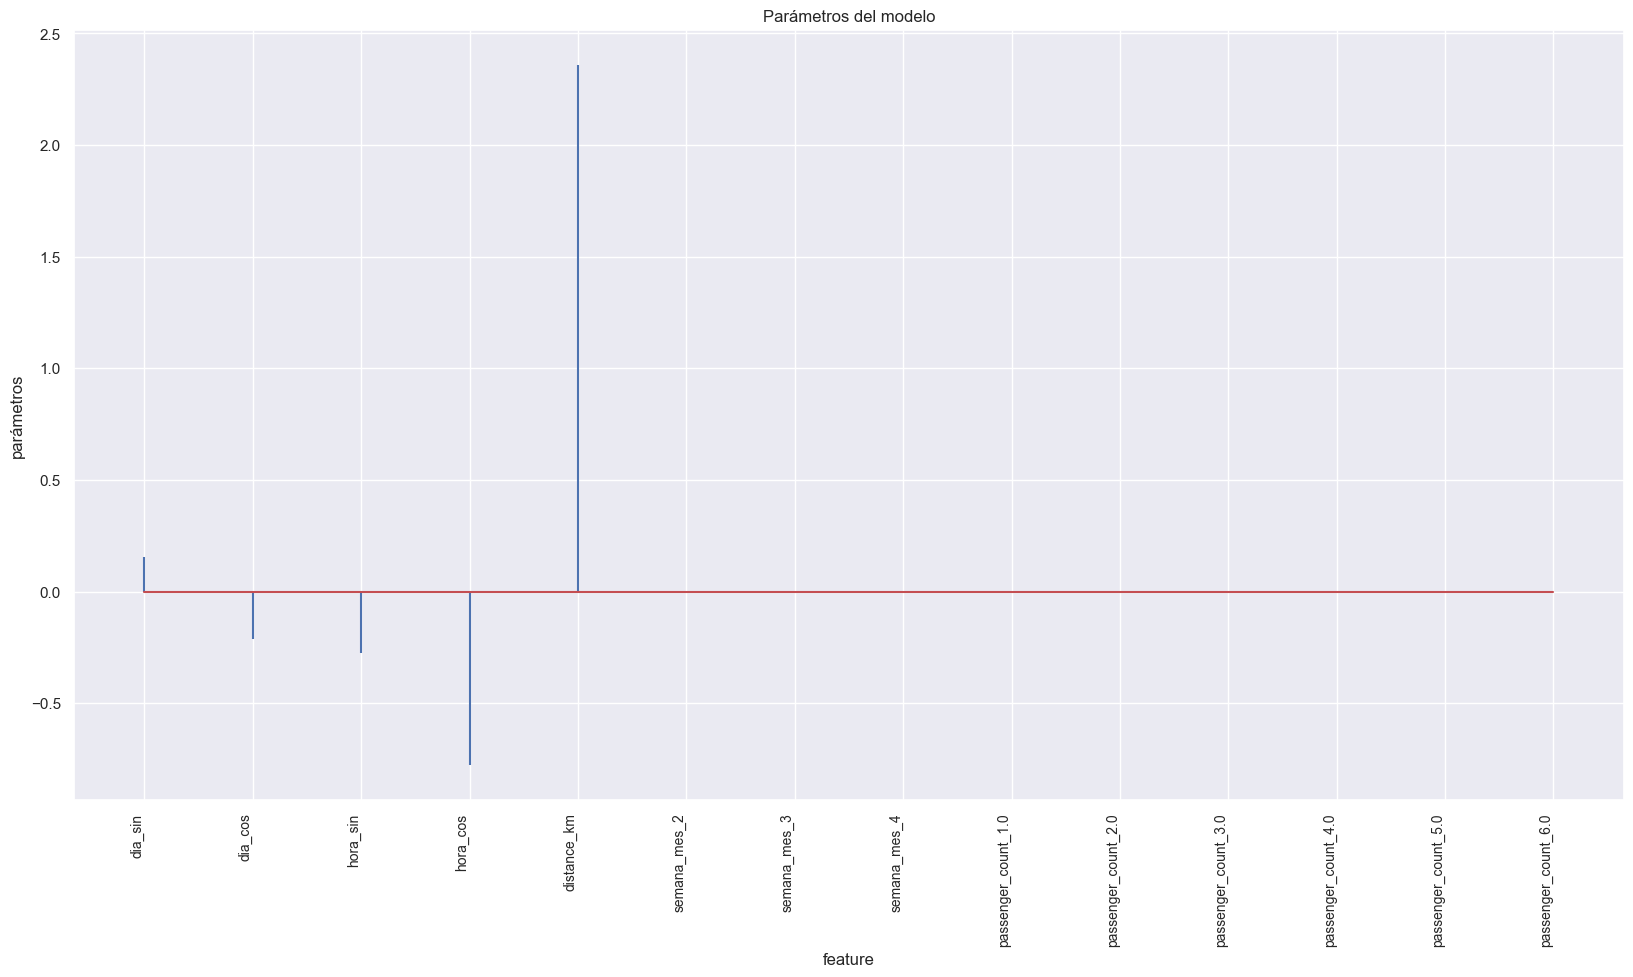

In [243]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

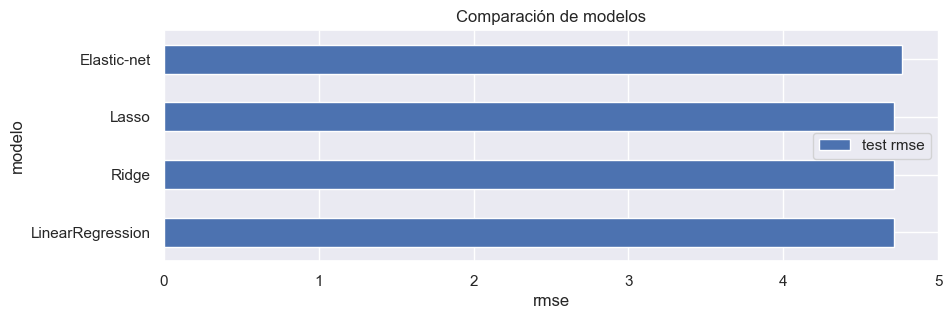

In [244]:
df_comparacion = pd.DataFrame({
                    'modelo': ['LinearRegression', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse, rmse_ridge, rmse_lasso, rmse_elastic_net]
                 })

fig, ax = plt.subplots(figsize=(10, 3))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');

como no tenemos overfitting por lo tanto lasso y ridge no mejoran con respecto a LR